# Parallel Recursive Filtering of Infinite Input Extensions
## This notebook tests alg5
### Algorithm 5 Zero-Padding Extension

In [1]:
import math
import cmath
import numpy as np
from scipy import ndimage, linalg
from skimage.color import rgb2gray
from skimage.measure import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
plt.gray() # to plot gray images using gray scale

In [2]:
%run 'all_functions.ipynb'

All functions loaded successfully!


## First: load the test image and run Gaussian filter on it

In [3]:
%%time
X1 = plt.imread('input.png')
X1 = rgb2gray(X1)
s = 16. # sigma for testing filtering
X2 = np.copy(X1).astype(np.float64)
# Gaussian filter runs with zero-border
X2 = ndimage.filters.gaussian_filter(X1, sigma=s, mode='constant')

Wall time: 51 ms


## Second: setup basic parameters from the input image

In [4]:
%%time
b = 32 # squared block size (b,b)
w = [ weights1(s), weights2(s) ] # weights of the recursive filter
width, height = X1.shape[1], X1.shape[0]
m_size, n_size = get_mn(X1, b)
blocks = break_blocks(X1, b, m_size, n_size)
# Pre-computation of matrices and pre-allocation of carries
alg5m1 = build_alg5_matrices(b, 1, w[0], width, height)
alg5m2 = build_alg5_matrices(b, 2, w[1], width, height)
alg5c1 = build_alg5_carries(m_size, n_size, b, 1)
alg5c2 = build_alg5_carries(m_size, n_size, b, 2)

Wall time: 40 ms


## Third: run alg5 with filter order 1 then 2

In [5]:
%%time
# Running alg5 with filter order r = 1
alg5_stage1(m_size, n_size, 1, w[0], alg5m1, alg5c1, blocks)
alg5_stage23(m_size, n_size, alg5m1, alg5c1)
alg5_stage45(m_size, n_size, alg5m1, alg5c1)
alg5_stage6(m_size, n_size, w[0], alg5c1, blocks)
# Running alg5 with filter order r = 2
alg5_stage1(m_size, n_size, 2, w[1], alg5m2, alg5c2, blocks)
alg5_stage23(m_size, n_size, alg5m2, alg5c2)
alg5_stage45(m_size, n_size, alg5m2, alg5c2)
alg5_stage6(m_size, n_size, w[1], alg5c2, blocks)
# Join blocks back together
X3 = join_blocks(blocks, b, m_size, n_size, X1.shape)

Wall time: 3.13 s


## Fourth: show both results and error measurements

[ Mean Squared Error: 0.00868603888373  ] [ Structural similarity: 0.940337722455  ]


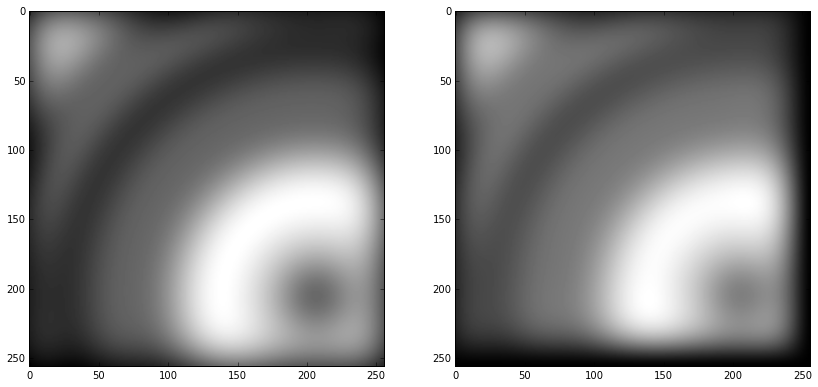

In [6]:
fig, (ax2, ax3) = plt.subplots(1, 2)
fig.set_figheight(9)
fig.set_figwidth(14)
ax2.imshow(X2)
ax3.imshow(X3)
print '[ Mean Squared Error:', mean_squared_error(X2, X3), ' ]',
print '[ Structural similarity:', ssim(X2, X3), ' ]'

## Conclusion: while direct convolution (left) is impacted only by the zero-border input, the recursive filtering (right) is impacted by the zero feedback from both input and output; since alg5 ignores borders the results is not the same (left differs from right)